# 국민청원 데이터로 이진 분류하기

* 예제로 응답여부를 0과 1로 예측합니다.
* 응답여부 외에도 청원의 카테고리를 예측하는 분류를 해볼 수도 있을것 같아요. 
* 이 예제를 참고하여 응답여부외에 청원내용으로 평균 이상의 투표를 받을 것인지 여부를 예측해 보면 좋겠습니다.

In [1]:
import pandas as pd
import numpy as np
import re
print(pd.__version__)
print(np.__version__)

0.21.0
1.14.0


# 데이터 로드하기

In [2]:
# 크롤링해 온 국민청원 데이터를 판다스를 통해 읽어옵니다.
petitions = pd.read_csv('data/petition.csv', parse_dates=['start', 'end'])
# 데이터의 크기가 어느정도인지 봅니다.
petitions.shape

(377756, 8)

In [3]:
petitions.describe()

,article_id,answered,votes
count,377756.000000,377756.000000,3.777560e+05
mean,239703.455924,0.000077,1.514069e+02
std,146382.863480,0.008761,4.842551e+03
min,21.000000,0.000000,0.000000e+00
25%,108933.750000,0.000000,1.000000e+00
50%,237637.000000,0.000000,5.000000e+00
75%,367937.250000,0.000000,1.500000e+01
max,492043.000000,1.000000,1.192049e+06


In [4]:
# 전체 데이터 중 투표가 1000건 이상인 데이터를 기준으로 가져옵니다. 아웃라이어 데이터 제거를 위해 20만건 이상 데이터도 제거합니다.
petition_remove_outlier = petitions.loc[(petitions['votes'] > 100) & (petitions['votes'] < 10000)]
petition_remove_outlier.shape

(17027, 8)

In [5]:
df = petition_remove_outlier.copy()

In [6]:
df.describe()

,article_id,answered,votes
count,17027.000000,17027.0,17027.000000
mean,264078.316967,0.0,688.654549
std,130088.137302,0.0,1285.122242
min,28.000000,0.0,101.000000
25%,169458.500000,0.0,142.000000
50%,258974.000000,0.0,228.000000
75%,382067.500000,0.0,541.000000
max,492036.000000,0.0,9988.000000


# 이진분류 대상 정하기
* 답변 여부에 대해 분류해보는 실습을 해볼까 했지만 표준편차가 너무 크고 모수가 적어 분류 데이터로 적합하지 않습니다.

In [7]:
# 답변대상건이 몇 건인지 봅니다. 
df.loc[df['answered'] == 1].shape

(0, 8)

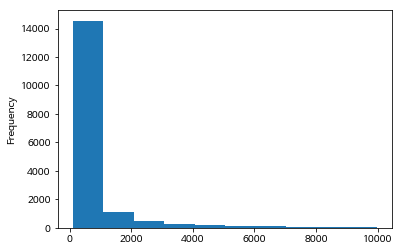

In [8]:
%matplotlib inline 
df['votes'].plot.hist()

# 투표수를 평균보다 높게 혹은 적게 받는지 예측해 보기

In [9]:
# 기본값을 0으로 세팅
df['votes_pos_neg'] = 0

In [10]:
# 평균 투표수를 구해 옵니다.
votes_mean = df['votes'].mean()
votes_mean

688.6545486580137

In [11]:
# 투표수가 평균을 넘으면 1로 다시 세팅합니다.
df['votes_pos_neg'] = (df['votes'] > votes_mean) == 1

In [12]:
# 타입을 boolean 에서 int로 변경해 줍니다.
df['votes_pos_neg'] = df['votes_pos_neg'].astype(int)

In [13]:
df.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,1
13,34,2017-08-19,2017-09-18,0,679,기타,『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 ...,(현황)\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊...,0
16,37,2017-08-19,2017-09-18,0,415,기타,황우석박사님 연구재개 허용 촉구합니다.,국민의 70% 이상이 황우석박사님을 응원하고 지지하고 있습니다.\n*2007년 1월...,0
18,40,2017-08-19,2017-09-18,0,218,외교/통일/국방,국가유공자등 예우및 지우너에 관한 법률 시행령 개정,지금부터 67년전 1950년 6.25전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,0
19,41,2017-08-19,2017-09-18,0,227,외교/통일/국방,국가유공자등 예우및 지우너에 관한 법률 시행령 개정,지금부터 67년전 1950년 6.25전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,0


In [14]:
# 샘플로 보고 싶은 인덱스의 번호를 넣어주세요.
sample_index = 38

In [15]:
sample_title = df['title'][sample_index]
sample_title

'영어회화전문강사제도는 유지되어야합니다.'

In [16]:
sample_content = petitions['content'][sample_index]
sample_content

'1. 영전강의고용안정을 원합니다\\n2.1년단위계약직으로 임신 출산육아 매우 곤란합니다\\n3. 성과급 호봉인정 상여금 급식비지원 전혀없으며 연봉인상 또한 없습니다\\n4.인권위의 무기직으로 전환 권고받았습니다\\n5.공공부문 비정규직 없애는건 문정부의 공약이며 이에따라 영전강만 제외하는것은 불공평합니다\\n저희는 정교사나 정규직을 원하는것이 아닙니다.\\n이 일을 계속 하길 희망할 뿐입니다.  문재인대통령님께선 일자리창출을 매우 중요하게 생각하셨습니다.  일자리창출 만큼 중요한것이 일자리 유지입니다.  창출만 하고 유지가 되지 않는다면 그저  형식적인 정책일 뿐입니다. 하루빨리 결과가 나와  안정된 마음으로 일하고 싶습니다.  감사합니다.'

# 전처리 하기 

In [17]:
def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    # 중복으로 생성된 공백값을 제거합니다.
    text = re.sub(' +', ' ', text)
    return text

In [18]:
# 불용어 제거
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = ['안녕', '있습니다', '그', '년도', '안녕하세요', '하는', '및', '제', '할', '하고', '더', '대한', '한', '그리고', '월', '저는', '없는', '입니다', '등', '일', '많은', '이런', '것은', '왜','같은', '같습니다', '없습니다', '위해', '한다']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [19]:
# 샘플데이터에 적용
pre_sample_content = preprocessing(sample_content)

In [20]:
pre_sample_content = remove_stopwords(pre_sample_content)

In [21]:
%time df['content_preprocessing'] = df['content'].apply(preprocessing)

CPU times: user 2.52 s, sys: 43.5 ms, total: 2.56 s
Wall time: 2.68 s


In [22]:
%time df['content_preprocessing2'] = df['content_preprocessing'].apply(remove_stopwords)

CPU times: user 2.19 s, sys: 50.8 ms, total: 2.24 s
Wall time: 2.55 s


# 학습세트와 테스트세트 만들기
* 학습세트와 테스트세트를 7:3의 비율로 나눠 줍니다.

In [23]:
df = df.reindex()

In [24]:
df.shape

(17027, 11)

In [25]:
split_count = int(df.shape[0] * 0.7)
split_count

11918

In [26]:
df_train = df[:split_count].copy()
df_train.shape

(11918, 11)

In [27]:
df_train.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessing2
7,28,2017-08-19,2017-08-26,0,2137,경제민주화,소액주주를 보호해주십시오,** 존경하옵는 문재인대통령님께\n저는 중국원양자원이라는 KOSPI상장사의 소액 ...,1,존경하옵는 문재인대통령님께 저는 중국원양자원이라는 KOSPI상장사의 소액 주주입니...,존경하옵는 문재인대통령님께 중국원양자원이라는 KOSPI상장사의 소액 주주입니다 중...
13,34,2017-08-19,2017-09-18,0,679,기타,『국가유공자 등 예우 및 지원에 관한법률』상「6.25전몰군경 자녀수당」의 불합리한 ...,(현황)\n우리들 아버지께서는 67여년전 북의 남침으로 조국이 위기에 처했을 때 젊...,0,현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은 목숨...,현황 우리들 아버지께서는 여년전 북의 남침으로 조국이 위기에 처했을 때 젊은 목숨...
16,37,2017-08-19,2017-09-18,0,415,기타,황우석박사님 연구재개 허용 촉구합니다.,국민의 70% 이상이 황우석박사님을 응원하고 지지하고 있습니다.\n*2007년 1월...,0,국민의 이상이 황우석박사님을 응원하고 지지하고 있습니다 년 월 중앙일보 여론조 국민...,국민의 이상이 황우석박사님을 응원하고 지지하고 년 중앙일보 여론조 국민 여론조사 황...
18,40,2017-08-19,2017-09-18,0,218,외교/통일/국방,국가유공자등 예우및 지우너에 관한 법률 시행령 개정,지금부터 67년전 1950년 6.25전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,0,지금부터 년전 년 전쟁때 조국 대한민국이 위태로운 시점에 우리들 아버님께서는 조국의...,지금부터 년전 년 전쟁때 조국 대한민국이 위태로운 시점에 우리들 아버님께서는 조국의...
19,41,2017-08-19,2017-09-18,0,227,외교/통일/국방,국가유공자등 예우및 지우너에 관한 법률 시행령 개정,지금부터 67년전 1950년 6.25전쟁때 조국 대한민국이 위태로운 시점에 우리들 ...,0,지금부터 년전 년 전쟁때 조국 대한민국이 위태로운 시점에 우리들 아버님께서는 조국의...,지금부터 년전 년 전쟁때 조국 대한민국이 위태로운 시점에 우리들 아버님께서는 조국의...


In [28]:
# 학습 세트에서 투표수가 평균보다 많은 건
df_train.loc[df_train['votes_pos_neg'] == 1].shape

(2467, 11)

In [29]:
df_test = df[split_count:].copy()
df_test.shape

(5109, 11)

In [30]:
df_test.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessing2
266455,346112,2018-08-18,2018-09-17,0,262,보건복지,★★【국민연금 폐지】★★ 눈에 잘띄게 재업!! 꼭 동의합니다. 눌러주세요!!,안녕하십니까? 친애하는 문재인 대통령님!\n몇칠전 뉴스에서 문재인 대통령님께서 국민...,0,안녕하십니까 친애하는 문재인 대통령님 몇칠전 뉴스에서 문재인 대통령님께서 국민연금 ...,안녕하십니까 친애하는 문재인 대통령님 몇칠전 뉴스에서 문재인 대통령님께서 국민연금 ...
266465,346124,2018-08-18,2018-09-17,0,156,정치개혁,안민석이 발의한 다문화 교육 지원법안 반대하는 국민여론들... 한국인 차별 외국계특...,국회사이트입법예고에 올라온 한국인차별하고 다문화에게만 각종 특혜조공하는 매국반민족 ...,0,국회사이트입법예고에 올라온 한국인차별하고 다문화에게만 각종 특혜조공하는 매국반민족 ...,국회사이트입법예고에 올라온 한국인차별하고 다문화에게만 각종 특혜조공하는 매국반민족 ...
266533,346222,2018-08-18,2018-09-17,0,231,교통/건축/국토,거제도-부산을 연결하는 거가대교 통행료 너무 비쌉니다.,안녕하세요.\n거제도에서 일하고 있는 직장인 입니다.\n다름이 아니라 거제도와 부산...,0,안녕하세요 거제도에서 일하고 있는 직장인 입니다 다름이 아니라 거제도와 부산을 연결...,거제도에서 일하고 있는 직장인 다름이 아니라 거제도와 부산을 연결하는거가대교 통행료...
266540,346230,2018-08-18,2018-09-17,0,219,육아/교육,"초,중,고 학생들을 지켜주세요",안녕하세요 고등학교 3학년 학생입니다.\n다름이 아니라 며칠전 친구가 사교육 받는다...,0,안녕하세요 고등학교 학년 학생입니다 다름이 아니라 며칠전 친구가 사교육 받는다는 이...,고등학교 학년 학생입니다 다름이 아니라 며칠전 친구가 사교육 받는다는 이유로 담임선...
266566,346274,2018-08-18,2018-09-17,0,4205,기타,새누리당 매크로 특검원합니다,이미 뉴스에 조작혐의 나온바 있는\n새누리당 매크로 특검 요청합니다\n대한민국의 모...,1,이미 뉴스에 조작혐의 나온바 있는 새누리당 매크로 특검 요청합니다 대한민국의 모든 ...,이미 뉴스에 조작혐의 나온바 있는 새누리당 매크로 특검 요청합니다 대한민국의 모든 ...


In [31]:
# 테스트 세트에서 투표수가 평균보다 많은 건
df_test.loc[df_test['votes_pos_neg'] == 1].shape

(1067, 11)

# 단어 벡터화 하기
## BOW(bag of words)
* 가장 간단하지만 효과적이라 널리쓰이는 방법
* 장, 문단, 문장, 서식과 같은 입력 텍스트의 구조를 제외하고 각 단어가 이 말뭉치에 얼마나 많이 나타나는지만 헤아립니다.
* 구조와 상관없이 단어의 출현횟수만 세기 때문에 텍스트를 담는 가방(bag)으로 생각할 수 있습니다.
* BOW는 단어의 순서가 완전히 무시 된다는 단점이 있다. 예를 들어 의미가 완전히 반대인 두 문장이 있다고 합니다.
    - `it's bad, not good at all.` 
    - `it's good, not bad at all.` 
* 위 두 문장은 의미가 전혀 반대지만 완전히 동일하게 반환됩니다.
* 이를 보완하기 위해 n-gram을 사용하는 데 BOW는 하나의 토큰을 사용하지만 n-gram은 n개의 토큰을 사용할 수 있도록 합니다.
* min_df는 문서에 특정 단어가 최소 몇 번 이상 문서에 등장하는 단어를 가방에 담겠다는 의미입니다.

* [Bag-of-words model - Wikipedia](https://en.wikipedia.org/wiki/Bag-of-words_model)

## 사이킷런의 CountVectorizer를 통해 벡터화
* 미리 전처리 해둔 텍스트 데이터로 벡터화 합니다.
* 모두 소문자로 변환시키기 때문에 영어의 경우 good, Good, gOod이 모두 같은 특성이 됩니다.
* 의미없는 특성을 많이 생성하기 때문에 적어도 두 번이상 문서에 나타난 토큰만을 사용한다.

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer = 'word', # 캐릭터 단위로 벡터화 할 수도 있습니다.
                             tokenizer = None, # 토크나이저를 따로 지정해 줄 수도 있습니다.
                             preprocessor = None, # 전처리 도구
                             stop_words = None, # 불용어 nltk등의 도구를 사용할 수도 있습니다.
                             min_df = 2, # 토큰이 나타날 최소 문서 개수로 오타나 자주 나오지 않는 특수한 전문용어 제거에 좋다. 
                             ngram_range=(1, 3), # BOW의 단위를 1~3개로 지정합니다.
                             max_features = 2000 # 만들 피처의 수, 단어의 수가 된다.
                            )
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=2000, min_df=2,
        ngram_range=(1, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [33]:
%%time 
train_feature_vector = vectorizer.fit_transform(df_train['content_preprocessing2'])
train_feature_vector.shape

CPU times: user 25.5 s, sys: 1.03 s, total: 26.6 s
Wall time: 26.9 s


In [34]:
%%time 
test_feature_vector = vectorizer.fit_transform(df_test['content_preprocessing2'])
test_feature_vector.shape

CPU times: user 14.8 s, sys: 617 ms, total: 15.4 s
Wall time: 15.7 s


In [35]:
vocab = vectorizer.get_feature_names()
print(len(vocab))
vocab[:10]

2000


['aid',
 'article',
 'articleview',
 'articleview html',
 'articleview html idxno',
 'a는',
 'cctv',
 'cctv를',
 'co',
 'co kr']

In [36]:
dist = np.sum(train_feature_vector, axis=0)

pd.DataFrame(dist, columns=vocab)

,aid,article,articleview,articleview html,articleview html idxno,a는,cctv,cctv를,co,co kr,...,훨씬,희망을,힘든,힘들게,힘들고,힘들어,힘듭니다,힘없는,힘을,힘이
0,220,161,145,122,418,401,173,852,157,146,...,122,231,470,328,127,133,154,188,363,220


## TF-IDF
TF(단어 빈도, term frequency)는 특정한 단어가 문서 내에 얼마나 자주 등장하는지를 나타내는 값으로, 이 값이 높을수록 문서에서 중요하다고 생각할 수 있다. 하지만 단어 자체가 문서군 내에서 자주 사용되는 경우, 이것은 그 단어가 흔하게 등장한다는 것을 의미한다. 이것을 DF(문서 빈도, document frequency)라고 하며, 이 값의 역수를 IDF(역문서 빈도, inverse document frequency)라고 한다. TF-IDF는 TF와 IDF를 곱한 값이다.

IDF 값은 문서군의 성격에 따라 결정된다. 예를 들어 '원자'라는 낱말은 일반적인 문서들 사이에서는 잘 나오지 않기 때문에 IDF 값이 높아지고 문서의 핵심어가 될 수 있지만, 원자에 대한 문서를 모아놓은 문서군의 경우 이 낱말은 상투어가 되어 각 문서들을 세분화하여 구분할 수 있는 다른 낱말들이 높은 가중치를 얻게 된다.

역문서 빈도(IDF)는 한 단어가 문서 집합 전체에서 얼마나 공통적으로 나타나는지를 나타내는 값이다. 전체 문서의 수를 해당 단어를 포함한 문서의 수로 나눈 뒤 로그를 취하여 얻을 수 있다.

* 출처 : [TF-IDF - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/TF-IDF)

\begin{equation*}
\text{tfidf}(w, d) = \text{tf} \times (\log\big(\frac{N + 1}{N_w + 1}\big) + 1)
\end{equation*}


* 싸이킷런 공식문서 : [4.2. Feature extraction — scikit-learn 0.19.1 documentation](http://scikit-learn.org/stable/modules/feature_extraction.html)

### TfidfTransformer()
* norm='l2' 각 문서의 피처 벡터를 어떻게 벡터 정규화 할지 정한다. 
    - L2 : 벡터의 각 원소의 제곱의 합이 1이 되도록 만드는 것이고 기본 값
    - L1 : 벡터의 각 원소의 절댓값의 합이 1이 되도록 크기를 조절
* smooth_idf=False
    - 피처를 만들 때 0으로 나오는 항목에 대해 작은 값을 더해서(스무딩을 해서) 피처를 만들지 아니면 그냥 생성할지를 결정
* sublinear_tf=False
* use_idf=True
    - TF-IDF를 사용해 피처를 만들 것인지 아니면 단어 빈도 자체를 사용할 것인지 여부

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False,
         use_idf=True)

In [38]:
%%time 
train_feature_tfidf = transformer.fit_transform(train_feature_vector)
train_feature_tfidf.shape

CPU times: user 32.3 ms, sys: 6.9 ms, total: 39.2 ms
Wall time: 38.9 ms


In [39]:
%%time 
test_feature_tfidf = transformer.fit_transform(test_feature_vector)
test_feature_tfidf.shape

CPU times: user 18.4 ms, sys: 3.31 ms, total: 21.7 ms
Wall time: 19.5 ms


In [40]:
test_feature_tfidf.shape

(5109, 2000)

# 랜덤 포레스트로 학습시키기
* 공식문서 : http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [41]:
from sklearn.ensemble import RandomForestClassifier

# 랜덤포레스트 분류기를 사용
forest = RandomForestClassifier(
    n_estimators = 100, n_jobs = -1, random_state=2018)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=2018, verbose=0,
            warm_start=False)

In [42]:
# 학습에 사용할 y_label 을 넣어준다.
y_label = df_train['votes_pos_neg']
%time forest = forest.fit(train_feature_tfidf, y_label)

CPU times: user 25.4 s, sys: 209 ms, total: 25.6 s
Wall time: 8.18 s


# 평가하기

In [43]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

scoring = 'accuracy'
score = cross_val_score(forest, train_feature_tfidf, y_label, cv=k_fold, n_jobs=-1, scoring=scoring)
score

array([0.79026846, 0.7852349 , 0.80159396, 0.79227864, 0.77801091])

In [44]:
round(np.mean(score)*100,2)

78.95

# 예측

In [45]:
# 테스트 데이터를 넣고 예측한다.
y_pred = forest.predict(test_feature_tfidf)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [46]:
y_pred.shape

(5109,)

In [47]:
# 예측 결과를 저장하기 위해 데이터프레임에 담아 준다.
output = pd.DataFrame(data={'votes_pos_neg_pred':y_pred})
output.head()

,votes_pos_neg_pred
0,0
1,0
2,0
3,0
4,0


In [48]:
# 0과 1이 어떻게 집계 되었는지 확인한다.
# 실제 데이터에는 답변 대상 건이 있는데 없는 것으로 예측되었다.
output['votes_pos_neg_pred'].value_counts()

0    5095
1      14
Name: votes_pos_neg_pred, dtype: int64

In [49]:
df_test['votes_pos_neg_pred'] = y_pred

In [50]:
df_test['pred_diff'] = np.abs(df_test['votes_pos_neg'] - df_test['votes_pos_neg_pred'])
df_test.head()

,article_id,start,end,answered,votes,category,title,content,votes_pos_neg,content_preprocessing,content_preprocessing2,votes_pos_neg_pred,pred_diff
266455,346112,2018-08-18,2018-09-17,0,262,보건복지,★★【국민연금 폐지】★★ 눈에 잘띄게 재업!! 꼭 동의합니다. 눌러주세요!!,안녕하십니까? 친애하는 문재인 대통령님!\n몇칠전 뉴스에서 문재인 대통령님께서 국민...,0,안녕하십니까 친애하는 문재인 대통령님 몇칠전 뉴스에서 문재인 대통령님께서 국민연금 ...,안녕하십니까 친애하는 문재인 대통령님 몇칠전 뉴스에서 문재인 대통령님께서 국민연금 ...,0,0
266465,346124,2018-08-18,2018-09-17,0,156,정치개혁,안민석이 발의한 다문화 교육 지원법안 반대하는 국민여론들... 한국인 차별 외국계특...,국회사이트입법예고에 올라온 한국인차별하고 다문화에게만 각종 특혜조공하는 매국반민족 ...,0,국회사이트입법예고에 올라온 한국인차별하고 다문화에게만 각종 특혜조공하는 매국반민족 ...,국회사이트입법예고에 올라온 한국인차별하고 다문화에게만 각종 특혜조공하는 매국반민족 ...,0,0
266533,346222,2018-08-18,2018-09-17,0,231,교통/건축/국토,거제도-부산을 연결하는 거가대교 통행료 너무 비쌉니다.,안녕하세요.\n거제도에서 일하고 있는 직장인 입니다.\n다름이 아니라 거제도와 부산...,0,안녕하세요 거제도에서 일하고 있는 직장인 입니다 다름이 아니라 거제도와 부산을 연결...,거제도에서 일하고 있는 직장인 다름이 아니라 거제도와 부산을 연결하는거가대교 통행료...,0,0
266540,346230,2018-08-18,2018-09-17,0,219,육아/교육,"초,중,고 학생들을 지켜주세요",안녕하세요 고등학교 3학년 학생입니다.\n다름이 아니라 며칠전 친구가 사교육 받는다...,0,안녕하세요 고등학교 학년 학생입니다 다름이 아니라 며칠전 친구가 사교육 받는다는 이...,고등학교 학년 학생입니다 다름이 아니라 며칠전 친구가 사교육 받는다는 이유로 담임선...,0,0
266566,346274,2018-08-18,2018-09-17,0,4205,기타,새누리당 매크로 특검원합니다,이미 뉴스에 조작혐의 나온바 있는\n새누리당 매크로 특검 요청합니다\n대한민국의 모...,1,이미 뉴스에 조작혐의 나온바 있는 새누리당 매크로 특검 요청합니다 대한민국의 모든 ...,이미 뉴스에 조작혐의 나온바 있는 새누리당 매크로 특검 요청합니다 대한민국의 모든 ...,0,1


In [51]:
pred_diff = df_test['pred_diff'].value_counts()
pred_diff

0    4030
1    1079
Name: pred_diff, dtype: int64

In [52]:
print('전체 {}건의 데이터 중 {}건 예측'.format(y_pred.shape[0], pred_diff[0]))

전체 5109건의 데이터 중 4030건 예측


In [53]:
acc = ( pred_diff[0] / y_pred.shape[0] ) *100 
print('예측 비율 {}'.format(acc))

예측 비율 78.88040712468194
